* [1. IMPORTING LIBRARIES](#1)
* [2. LOADING DATA](#2)
* [3. DATA PREPREPROCESSING](#3)
* [4. Data Visualization](#4)
* [5. Splitting dataset](#5)
* [6. VECTORIZATION](#6)
* [7. MODEL BUILDING](#7)
* [8. Model Evaluation](#8)



# IMPORTING LIBRARIES

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
from string import punctuation
import re

nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from spacy.lang.en import English

from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

# Models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix , f1_score , accuracy_score ,recall_score,auc,roc_curve


from wordcloud import WordCloud

from gensim.models import word2vec

import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
np.random.seed(49)

# LOADING DATA

In [2]:
easy_ham_path = 'easy_ham/'
hard_ham_path = 'hard_ham/'
spam_path = 'spam_2/'

In [3]:
def get_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        f = open(path+file, encoding = "ISO-8859-1")
        words_list = f.read()
        data.append(words_list)
        f.close()
    return data

- on recupere les donnees

In [4]:
easy_ham = get_data(easy_ham_path)
hard_ham = get_data(hard_ham_path)
ham = easy_ham + hard_ham
spam = get_data(spam_path)





In [5]:
print(len(ham))
print(len(spam))

2801
1397


In [ ]:
#print(spam[49]) # take a look to the structure of our data


# DATA PREPREPROCESSING

- les Non-Mots

In [6]:
nltk_stopwords = set(stopwords.words("english"))
sklearn_stopwords = set(ENGLISH_STOP_WORDS)

list_of_stop_words = list(nltk_stopwords.union(sklearn_stopwords)) + ["<",">"]

- Regex

In [7]:

#regex pour les tags html
# html_supp=re.compile("<.*\n*.+>")
html_supp=re.compile(r"<\/?.+?\n*.+>")

#regex pour les URL
url_sub=re.compile(r"https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)")

#regex pour les Emails
email_sub=re.compile(r"[\w\-.]+@[\w\-.]+(\.\w{2,3})")
# email_sub=re.compile(r"\w+([\.-]?\w+)*@\w+([\.-]?\w+)*(\.\w{2,3})+")

#regex pour les nombres
#num_sub=re.compile(r"\b[0-9]+([.,:\s]+[0-9]+)*\b")
#num_sub=re.compile(r"\b[0-9]+\b")
num_sub=re.compile(r"[0-9]+")

#regex pour $
dollar_sub=re.compile(r"(\$)+")

#regex pour les espaces
space_sub=re.compile(r"\s+")



- Stemmer & Lemmatizer

In [8]:

nlp = English()#modele de nlp en anglais,on va l'utiliser pour la tokenization

stemmer = PorterStemmer() #stemming

lemmatizer = WordNetLemmatizer()#lemmatization


In [9]:
def clean_emails(email):

        # miniscule
        email = email.lower()
        
        #html supp
        email = re.sub(html_supp,"",email)
        
        #email adresse replace
        email = re.sub(email_sub,"emailaddr",email)
        
        # #url replace
        
        email = re.sub(url_sub,"httpaddr",email)
    
      
        # #numbers replace
        
        email = re.sub(num_sub,"nombre",email)
       
        # #dollar sign replace
        
        email = re.sub(dollar_sub,"dollar",email)
        
        # #whitespaces  replace
        email = re.sub(space_sub," ",email)

        
        #tokenization
        
        tokens = [lemmatizer.lemmatize(stemmer.stem(token.text))  for token in nlp.tokenizer(email) if not token.is_punct and str(token) not in list_of_stop_words]
        
        return tokens
    
    

In [10]:
ham_cleaned = list(map(clean_emails,ham))
spam_cleaned = list(map(clean_emails,spam))

print("Emails cleaned !")

Emails cleaned !


# Data Visualization

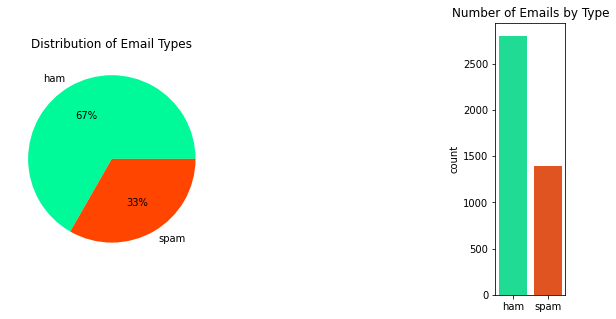

In [72]:
data = [len(ham)/len(ham+spam), len(spam)/len(ham+spam)]
labels = ['ham', 'spam']
colors = ['mediumspringgreen', 'orangered']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5),gridspec_kw={'width_ratios': [3, 1]})

ax1.pie(data, labels=labels, autopct='%.0f%%', colors=colors)
ax1.set_title('Distribution of Email Types')
sns.countplot(x=['ham']*len(ham) + ['spam']*len(spam), palette=colors, ax=ax2)
ax2.set_title('Number of Emails by Type')
plt.subplots_adjust(wspace=2.0)

plt.show()


In [11]:
def plot_WordCloud(text_list):
    text_list = ["".join(email) for email in text_list]
    unique_string=(" ").join(text_list)
    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

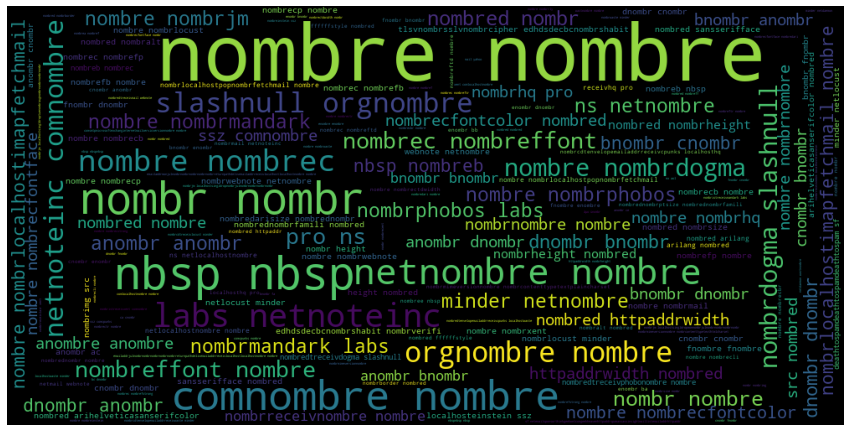

In [12]:
plot_WordCloud(spam_cleaned)

In [14]:
len(ham_cleaned)

2801

# VECTORIZATION

In [13]:
def vocabulary(emails,k=5):
    
    """
    emails : list of emails, each email is represented by a list of words
    
    k : a threshold, we  keep words that has a count > k
    
    """
    # all words in one list
    words_list = [word for email in emails for word in email]
    
    #a dictionnary where each word represent the key and the value is the word's count
    words_count_dict = dict(sorted(list(Counter(words_list).items()),key = lambda x :x[1] , reverse=True))
    
    #We keep words that has a count > k
    filtered_word_dict = dict(filter(lambda item: item[1] > k, words_count_dict.items()))
    
    #indexed words dictionnary
    word_to_index = { w : i for i,w in enumerate(filtered_word_dict.keys())}   
    
    return word_to_index
    

- usually we index all the vocabulary  (ham + spam) ,  but since we were asked to use only spam we indexed spam only which results a really small vocabulary (<10 000)

In [14]:
#indexed_vocabulary = vocabulary(ham_cleaned+spam_cleaned,10)
indexed_vocabulary = vocabulary(spam_cleaned,5)
len(indexed_vocabulary)

5069

In [18]:
list(indexed_vocabulary.items())[:5]

[('nombr', 0),
 ('=', 1),
 ('emailaddr', 2),
 ('receiv', 3),
 ('nombre.nombre.nombre.nombr', 4)]

In [19]:
def vectorization_bin(list_of_mails , vocab):
    
    """
    list_of_mails : list of emails , each email is represented with a list of its words
    
    vocab : a dictionnary where the key is a word and the value is a unique index
    
    """
  
    list_of_vects =[]
    
    for mail in list_of_mails:
        
        vect = [0]*len(vocab)
        
        for word in mail:
            
            if vocab.get(word,0):
                
                vect[vocab[word]]=1
                
        list_of_vects.append(vect)
        
    return np.array(list_of_vects)



In [20]:
def vectorization_comptage(list_of_mails , vocab):

    """
    list_of_mails : list of emails , each email is represented with a list of its words
    
    vocab : a dictionnary where the key is a word and the value is a unique index
    
    """
    list_of_vects =[]
    
    for mail in list_of_mails:
        
        vect = [0]*len(vocab)
        
        for word in mail:
            
            if vocab.get(word,0):
                vect[vocab[word]]+=1
                
        list_of_vects.append(vect)
        
    return np.array(list_of_vects)

- We can use `CountVectorizer`which is predefined in **Sklearn** but we were asked to implement it ourselves .

In [21]:
ham_vectorized_bin = vectorization_bin(ham_cleaned , indexed_vocabulary)
spam_vectorized_bin = vectorization_bin(spam_cleaned , indexed_vocabulary)

In [22]:
print(ham_vectorized_bin.shape)
print(spam_vectorized_bin.shape)

(2801, 5069)
(1397, 5069)


In [25]:
spam_vectorized_bin[:5]

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

# Splitting dataset

**1** pour spam et **0** pour ham

In [26]:
X = np.append(ham_vectorized_bin,spam_vectorized_bin,axis=0)

y = ham_vectorized_bin.shape[0]*[0] + spam_vectorized_bin.shape[0]*[1]


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=1, 
                                                    test_size=0.3)

# MODEL BUILDING

- ### Random Forest

In [28]:
rfc = RandomForestClassifier(n_estimators=1200)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1200)

In [29]:
y_pred_rfc = rfc.predict(X_test)

print(f"accuracy score = {accuracy_score(y_test, y_pred_rfc)}")
print(f"f1 score = {f1_score(y_test, y_pred_rfc)}")

accuracy score = 0.9912698412698413
f1 score = 0.9869203329369798


- ### Decision Tree

In [31]:
clf = DecisionTreeClassifier()

clf = clf.fit(X_train,y_train)

In [32]:
y_pred_dt = clf.predict(X_test)

print(f"accuracy score = {accuracy_score(y_test, y_pred_dt)}")
print(f"f1 score = {f1_score(y_test, y_pred_dt)}")

accuracy score = 0.9841269841269841
f1 score = 0.9760191846522782


- ### SVM

In [36]:
clf = SVC(kernel='linear')  # Linear kernel
clf.fit(X_train, y_train)



SVC(kernel='linear')

In [37]:
# Make predictions on the test data
y_pred_svm = clf.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy)

Accuracy: 0.9952380952380953


- ### Logistic Regression

In [38]:
clf = LogisticRegression()
clf.fit(X_train, y_train)


LogisticRegression()

In [39]:
y_pred_lr = clf.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy)

Accuracy: 0.9936507936507937


- ### KNN

In [40]:
clf = KNeighborsClassifier(n_neighbors=5)  # Use 5 nearest neighbors
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [41]:
y_pred_knn = clf.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", accuracy)

Accuracy: 0.9825396825396825


- ### XGBOOST

In [42]:
# Create an XGBoost classifier
xgb_clf = XGBClassifier(random_state=45)

# Train the classifier on the training set
xgb_clf.fit(X_train, y_train)

[14:31:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=45,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
# Make predictions on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Calculate accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)

Accuracy: 0.9976190476190476


- ### Naive Bayes

In [45]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [47]:
y_pred_nb = nb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_nb))

Accuracy: 0.903968253968254


## Neural Net

In [48]:
# Create the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
# Train the model
model.fit(np.array(X_train, dtype=int), np.array(y_train, dtype=int), epochs=10, batch_size=32)


Epoch 1/10
92/92 [==============================] - 2s 6ms/step - loss: 0.2152 - accuracy: 0.9142
Epoch 2/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0271 - accuracy: 0.9922
Epoch 3/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0116 - accuracy: 0.9973
Epoch 4/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0044 - accuracy: 0.9997
Epoch 5/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0043 - accuracy: 0.9986
Epoch 6/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 7/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 8/10
92/92 [==============================] - 1s 6ms/step - loss: 8.4609e-04 - accuracy: 1.0000
Epoch 9/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.9997
Epoch 10/10
92/92 [==============================] - 1s 6ms/step - loss: 6.0108e-04 - accuracy: 1.0000


In [50]:
# Evaluate the model on the test set
scores = model.evaluate(np.array(X_test, dtype=int), np.array(y_test, dtype=int), verbose=1)
#y_pred_nn = model.predict(X_test)

#y_pred_nn = np.argmax(y_pred_nn, axis=1)
#accuracy = accuracy_score(y_test, y_pred_nn)
#print("Accuracy:", accuracy)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

40/40 [==============================] - 0s 3ms/step - loss: 0.0333 - accuracy: 0.9929
Test loss: 0.033277902752161026
Test accuracy: 0.9928571581840515


# Model Evaluation

# bars

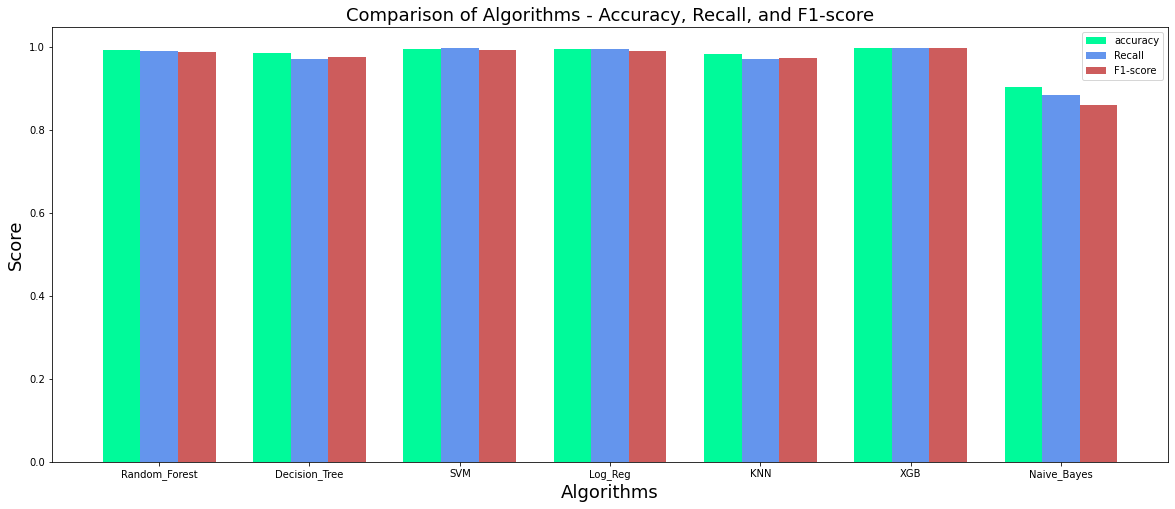

In [107]:
# Data for the algorithms
algorithms = ['Random_Forest', 'Decision_Tree', 'SVM', 'Log_Reg', 'KNN','XGB','Naive_Bayes']
accuracy = [accuracy_score(y_test, y_pred_rfc),accuracy_score(y_test, y_pred_dt),accuracy_score(y_test, y_pred_svm),
            accuracy_score(y_test, y_pred_lr),accuracy_score(y_test, y_pred_knn),accuracy_score(y_test, y_pred_xgb),
            accuracy_score(y_test, y_pred_nb)]

recall = [recall_score(y_test, y_pred_rfc),recall_score(y_test, y_pred_dt),recall_score(y_test, y_pred_svm),
            recall_score(y_test, y_pred_lr),recall_score(y_test, y_pred_knn),recall_score(y_test, y_pred_xgb),
            recall_score(y_test, y_pred_nb)]

f1_scores = [f1_score(y_test, y_pred_rfc),f1_score(y_test, y_pred_dt),f1_score(y_test, y_pred_svm),
            f1_score(y_test, y_pred_lr),f1_score(y_test, y_pred_knn),f1_score(y_test, y_pred_xgb),
            f1_score(y_test, y_pred_nb)]

# Set the width of each bar
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = range(len(algorithms))
r2 = [x + bar_width for x in r1]
r3 = [x + 2*bar_width for x in r1]

plt.figure(figsize=(20,8))

# Create the bar chart
plt.bar(r1, accuracy, color='mediumspringgreen', width=bar_width, label='accuracy')
plt.bar(r2, recall, color='cornflowerblue', width=bar_width, label='Recall')
plt.bar(r3, f1_scores, color='indianred', width=bar_width, label='F1-score')

# Set the x-axis labels and title
plt.xlabel('Algorithms', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.title('Comparison of Algorithms - Accuracy, Recall, and F1-score', fontsize=18)

# Set the x-axis tick positions and labels
plt.xticks([r + bar_width for r in range(len(algorithms))], algorithms)

# Add a legend
plt.legend()


# Show the bar chart
plt.show()

# roc

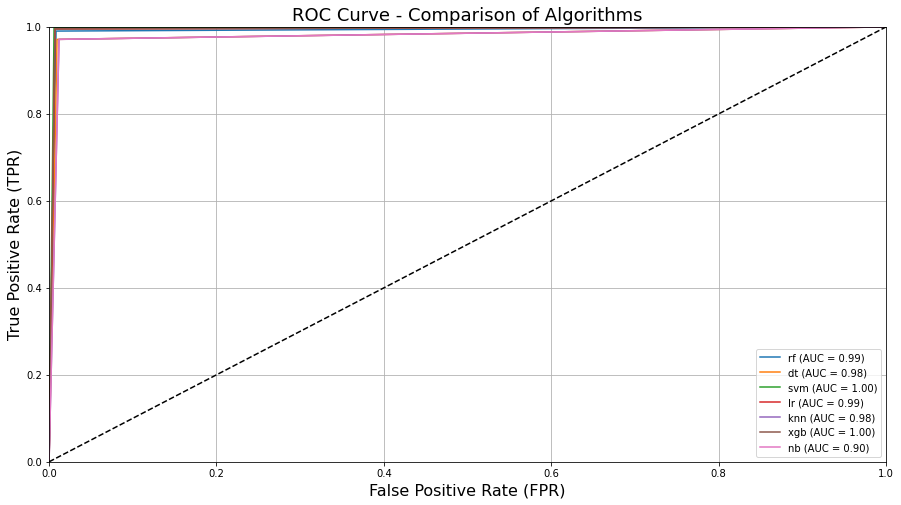

In [127]:
# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and Area Under the ROC curve (AUC) for each algorithm
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rfc)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb)

# Calculate AUC for each algorithm
auc_rf = auc(fpr_rf, tpr_rf)
auc_dt = auc(fpr_dt, tpr_dt)
auc_svm = auc(fpr_svm, tpr_svm)
auc_lr = auc(fpr_lr, tpr_lr)
auc_knn = auc(fpr_knn, tpr_knn)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(15,8))
plt.grid(True)
plt.axis([0, 1, 0, 1])
# Plot the combined ROC curve
plt.plot(fpr_rf, tpr_rf, label='rf (AUC = {:.2f})'.format(auc_rf))
plt.plot(fpr_dt, tpr_dt, label='dt (AUC = {:.2f})'.format(auc_dt))
plt.plot(fpr_svm, tpr_svm, label='svm (AUC = {:.2f})'.format(auc_svm))
plt.plot(fpr_lr, tpr_lr, label='lr (AUC = {:.2f})'.format(auc_lr))
plt.plot(fpr_knn, tpr_knn, label='knn (AUC = {:.2f})'.format(auc_knn))
plt.plot(fpr_lr, tpr_lr, label='xgb (AUC = {:.2f})'.format(auc_xgb))
plt.plot(fpr_knn, tpr_knn, label='nb (AUC = {:.2f})'.format(auc_nb))
plt.plot([0, 1], [0, 1], 'k--')

# Set x-axis and y-axis labels
plt.xlabel('False Positive Rate (FPR)',fontsize=16)
plt.ylabel('True Positive Rate (TPR)',fontsize=16)
plt.title('ROC Curve - Comparison of Algorithms',fontsize=18)
plt.legend(loc='lower right')  # Add a legend in the lower right corner

# Show the ROC curve
plt.show()

In [124]:
print("accuracy score = {}%".format(round(accuracy_score(y_test, y_pred_rfc)*100, 2)))
print("f1 score = {}".format(round(f1_score(y_test, y_pred_rfc), 2)))

accuracy score = 99.13%
f1 score = 0.99


In [125]:
conf_mx = confusion_matrix(y_test, y_pred_rfc)

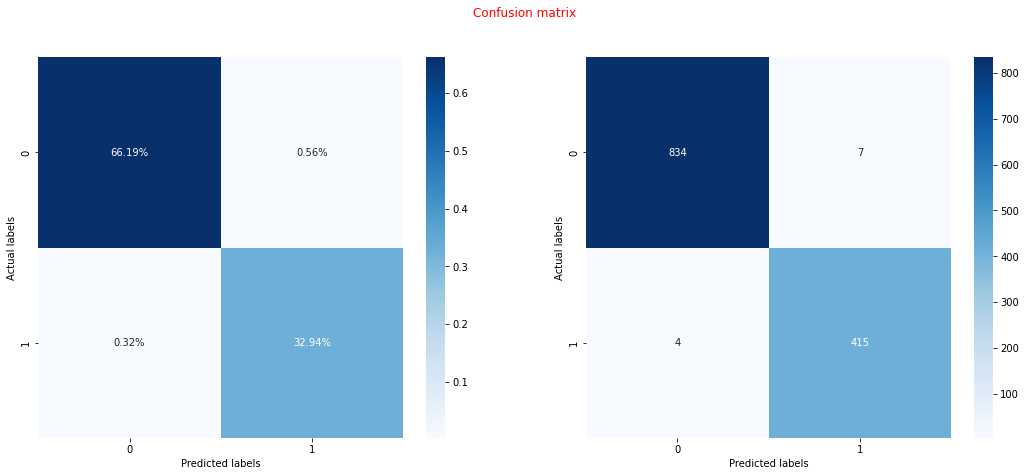

In [126]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('Confusion matrix', c='r')
sns.heatmap(conf_mx/np.sum(conf_mx), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('Actual labels')

sns.heatmap(conf_mx, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('Actual labels')
plt.show()